In [1]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

import os
import re
import ast
import math
import time
import warnings
import numpy as np 
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.style as style

from glob import glob
from PIL import Image, ImageDraw 
from tqdm import tqdm
from dask import bag

import tensorflow as tf
import tensorflow.keras as K
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.metrics import top_k_categorical_accuracy
from tensorflow.keras.callbacks import ModelCheckpoint,TensorBoard
from tensorflow.keras.layers import Activation, Reshape, Conv2DTranspose, UpSampling2D 
from tensorflow.keras.layers import Input, Dense, Conv2D, BatchNormalization, Dropout, Flatten, Activation

warnings.filterwarnings('ignore') # to suppress some matplotlib deprecation warnings
%matplotlib inline
%config InlineBackend.figure_format = 'retina'


from keras.models import Sequential, Model
from keras.layers import Input, Dense, BatchNormalization, Dropout, Flatten
from keras.layers import Conv2D, Conv2DTranspose, UpSampling2D, Reshape, Flatten
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import Adam, SGD
from keras.initializers import RandomNormal
from keras.backend import clear_session
np.random.seed(0)

from google.colab import drive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth 
from oauth2client.client import GoogleCredentials
drive.mount('/content/drive')

Found GPU at: /device:GPU:0
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Using TensorFlow backend.


In [2]:
width = 5

img_h, img_w = 64, 64

def top_3_accuracy(x,y): 
    t3 = top_k_categorical_accuracy(x,y, 3)
    return t3

def draw_it(strokes): 
    image = Image.new("P", (256,256), color=255)
    image_draw = ImageDraw.Draw(image)
    for stroke in ast.literal_eval(strokes):
        for i in range(len(stroke[0])-1):
            image_draw.line([stroke[0][i], 
                             stroke[1][i],
                             stroke[0][i+1], 
                             stroke[1][i+1]],
                            fill=0, width = width)
    image = image.resize((img_h, img_w))
    return np.array(image)/255.

numstonames = {0: 'banana', 1: 'bandage', 2: 'bear', 3: 'bed', 4: 'bee', 5: 'belt', 6: 'cactus', 7: 'cake', 8: 'coffee_cup', 9: 'door', 10: 'fork', 11: 'giraffe', 12: 'hand', 13: 'key', 14: 'laptop', 15: 'light_bulb', 16: 'marker', 17: 'paintbrush', 18: 'popsicle', 19: 'raccoon', 20: 'rain', 21: 'roller_coaster', 22: 'snail', 23: 'spoon', 24: 'swan', 25: 'The_Great_Wall_of_China', 26: 'toaster', 27: 'train', 28: 'whale', 29: 'wine_bottle'}

classifier_model = 'drive/My Drive/AI/my_model_1229.h5'

classifier_model = tf.keras.models.load_model(classifier_model, custom_objects={'top_3_accuracy': top_3_accuracy})
num_examples = 10
latent_dim = 100


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [3]:
correct_label = "roller_coaster"
generator_model = "drive/My Drive/AI/Gan_model/roller_coaster/roller_coaster_100_11.h5"
gen_model = tf.keras.models.load_model(generator_model)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [0]:

# random_noise = np.random.normal(0, 1, size=[num_examples, latent_dim])
# gen_imgs = gen_model.predict(random_noise)
# gen_imgs = gen_imgs.reshape(num_examples, img_h, img_w)

# plt.figure(figsize=(8, 8))

# correct = 0

# for i in range(gen_imgs.shape[0]):
#     grapharray = gen_imgs[i]
    
#     plt.subplot(2, 5, i+1)
#     plt.imshow(grapharray, interpolation='nearest', cmap='gray_r')
#     plt.axis('off')

#     for j in range(64):
#         for k in range(64):
#             # to check
#             if grapharray[j][k] < 0.6 : grapharray[j][k] = 1
#             else: grapharray[j][k] = 0

#     matplotlib.image.imsave('drive/My Drive/AI/Gan_generate_png_csv/' + correct_label + "/" + correct_label + "_" + str(i+1) + '.png', grapharray, cmap='gray_r')
#     np.savetxt('drive/My Drive/AI/Gan_generate_png_csv/' + correct_label + "/" + correct_label + "_" + str(i+1) + '.csv', grapharray, delimiter=",")
#     grapharray = np.reshape(grapharray, (1, img_h, img_w, 1))
#     graphpreds = classifier_model.predict(grapharray, verbose=0)
#     gvs = np.argsort(-graphpreds)

#     for idx in gvs[:]: 
#         if numstonames[idx[0]] == correct_label : correct = correct + 1

# print("Acc = ",  correct / num_examples)
# plt.suptitle("Samples from G")
# plt.show()

roller_coaster The_Great_Wall_of_China whale
roller_coaster marker hand
roller_coaster raccoon swan
roller_coaster The_Great_Wall_of_China paintbrush
roller_coaster hand The_Great_Wall_of_China
roller_coaster The_Great_Wall_of_China marker
roller_coaster marker paintbrush
roller_coaster paintbrush marker
roller_coaster paintbrush marker
roller_coaster paintbrush The_Great_Wall_of_China


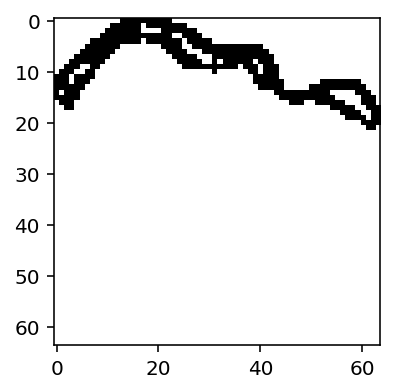

<Figure size 216x216 with 0 Axes>

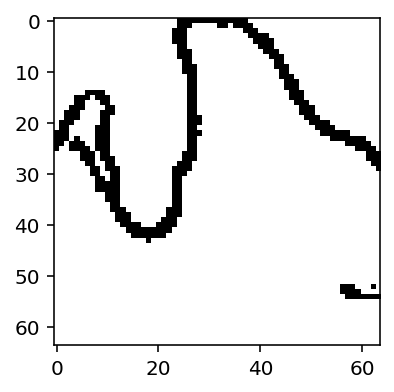

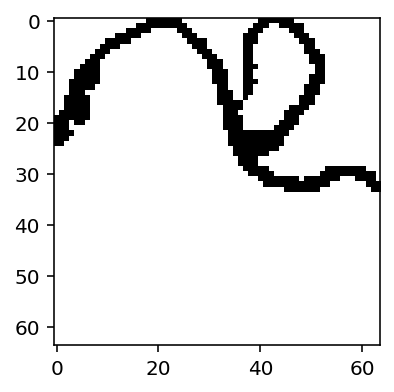

<Figure size 216x216 with 0 Axes>

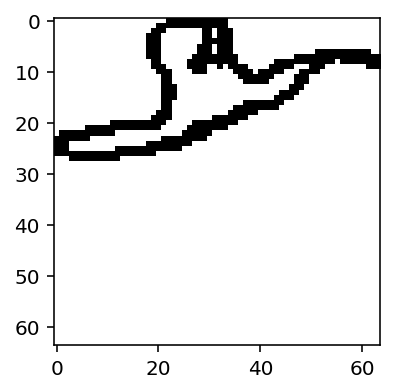

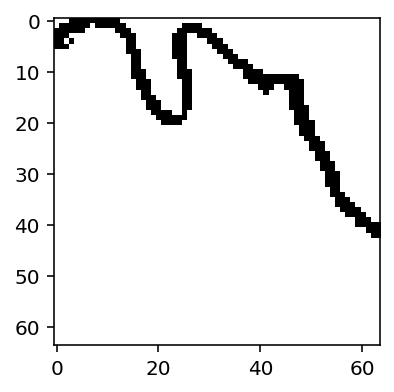

<Figure size 216x216 with 0 Axes>

<Figure size 216x216 with 0 Axes>

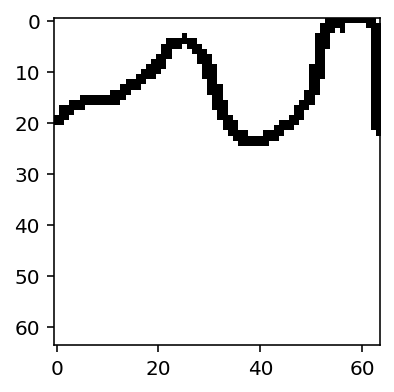

<Figure size 216x216 with 0 Axes>

<Figure size 216x216 with 0 Axes>

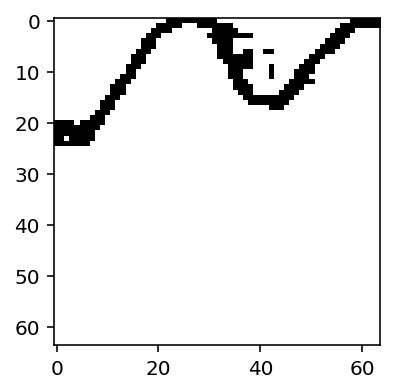

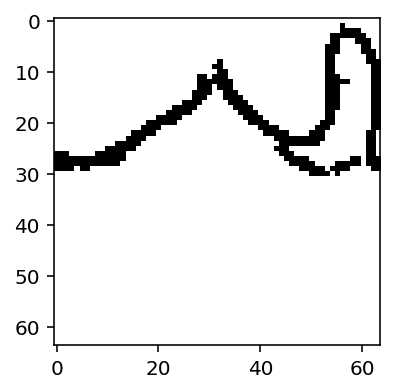

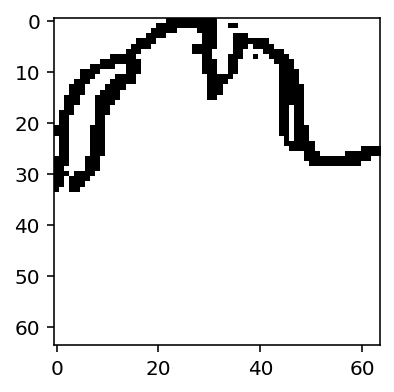

<Figure size 216x216 with 0 Axes>

<Figure size 216x216 with 0 Axes>

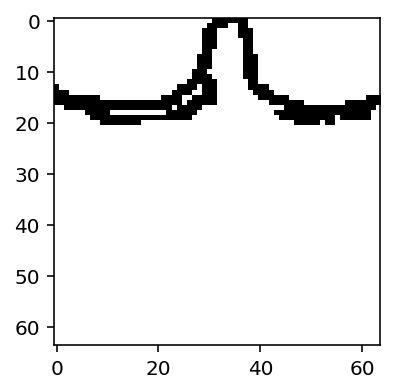

In [5]:

suc = 0
index = 0

while suc < num_examples:

  random_noise = np.random.normal(0, 1, size=[1, latent_dim])
  gen_imgs = gen_model.predict(random_noise)
  gen_imgs = gen_imgs.reshape(1, img_h, img_w)

  plt.figure(figsize=(3, 3))

  for i in range(gen_imgs.shape[0]):
      grapharray = gen_imgs[i]
      
      for j in range(64):
          for k in range(64):
              if grapharray[j][k] < 0.6 : grapharray[j][k] = 1
              else: grapharray[j][k] = 0

      to_test = np.reshape(grapharray, (1, img_h, img_w, 1))
      graphpreds = classifier_model.predict(to_test, verbose=0)
      gvs = np.argsort(-graphpreds)

      for idx in gvs[:]: 
          if numstonames[idx[0]] == correct_label : 
            print(numstonames[idx[0]], numstonames[idx[1]], numstonames[idx[2]])
            plt.imshow(grapharray, interpolation='nearest', cmap='gray')

            matplotlib.image.imsave('drive/My Drive/AI/Gan_generate_png_csv/' + correct_label + "/" + correct_label + "_" + str(index+1) + '.png', grapharray, cmap='gray_r')
            np.savetxt('drive/My Drive/AI/Gan_generate_png_csv/' + correct_label + "/" + correct_label + "_" + str(index+1) + '.csv', grapharray, delimiter=",")

            index += 1
            suc += 1